## 1 Installs & Imports

In [ ]:
"""
!pip install transformers
!pip install datasets
"""

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import spearmanr
import torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")

## 2 Data Loading

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining file path and loading the data

In [ ]:
file_path = '/content/drive/My Drive/Work Project/Data/Rotten Tomatoes/archive/rotten_tomatoes_critic_reviews.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the DataFrame
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


## 3 Data Exploration

### 3.1 Review Score

#### 3.1.1 Distribution

In [ ]:
# Analyze the distribution of review scores
print(df['review_score'].value_counts())

review_score
3/5        90273
4/5        83659
3/4        72366
2/5        60174
2/4        47546
           ...  
69/70          1
2.5/20         1
5.55/10        1
35             1
9.56/10        1
Name: count, Length: 814, dtype: int64


#### 3.1.2 Missing Values

In [ ]:
# Display the number of rows before cleaning
print(f"Number of rows before removing missing review scores: {df.shape[0]}")

Number of rows before removing missing review scores: 1130017


In [ ]:
# Check for missing values in the 'review_score' column
missing_review_scores = df['review_score'].isnull().sum()

print(f"Number of missing values in 'review_score': {missing_review_scores}")


Number of missing values in 'review_score': 305936


In [ ]:
# Drop rows with missing values in the 'review_score' column
df_cleaned = df.dropna(subset=['review_score'])

# Display the number of rows after cleaning
print(f"Number of rows after removing missing review scores: {df_cleaned.shape[0]}")


Number of rows after removing missing review scores: 824081


#### 3.1.3 Unique Values

In [ ]:
# Display the unique values in the 'review_score' column
unique_scores = df_cleaned['review_score'].unique()
print(f"Unique review scores: {unique_scores}")

# Sort and display the review scores for better clarity
sorted_scores = sorted(unique_scores)
print(f"Sorted review scores: {sorted_scores}")

# Display the distribution of review scores
score_distribution = df_cleaned['review_score'].value_counts().sort_index()
print(f"Review score distribution:\n{score_distribution}")


Unique review scores: ['3.5/5' '1/4' 'B' '3/5' '4/5' '2/4' '2/5' 'C' '2.5/4' '3/4' 'C-' '2.75/5'
 'B-' '2.5/5' '5.5/10' '1/5' 'C+' 'D+' '1.5/4' '6.5/10' '3/10' '1.5/5'
 '4/10' '7/10' '6/10' 'B+' '5/5' 'A-' '4.5/5' '5.78/10' '3.5/4' 'A' '9/10'
 '8.5/10' '4/4' '83/100' '8/10' '92/100' '82/100' '84/100' '10/10' 'D-'
 'F' '0.5/4' 'D' '5/10' '2/10' '2/6' '0.5/5' '0/4' '0/5' '76/100' '87/100'
 '74/100' '86/100' '81/100' '56/100' '78/100' '2.25/5' '8.8/10' '0/10'
 '44/100' '2.75/4' '2.4/5' '8.6/10' '79/100' '68/100' '80/100' '90/100'
 '66/100' '91/100' '0.3/5' '9.2/10' '2.7/5' '57/100' '4/6' '3/6' '73/100'
 '42/100' '65/100' '7.5/10' '4.5/10' '5/6' '1/6' '70/100' '3.5/10'
 '71/100' '0.1/5' '3.25/10' '89/100' '40/100' '64/100' '62/100' '1/10'
 '3.75/5' '37/100' '49/100' '60/100' '3.3/5' '77/100' '5.25/10' '1.4/4'
 '75/100' '1.5/6' '85/100' '4.25/10' '47/100' '6/8' '52/100' '63/100'
 '50/100' '41/100' '46/100' '6.95/10' '53/100' '9.5/10' '59/100' '43/100'
 '9.45/10' '45/100' '69/100' '7.25/10' 

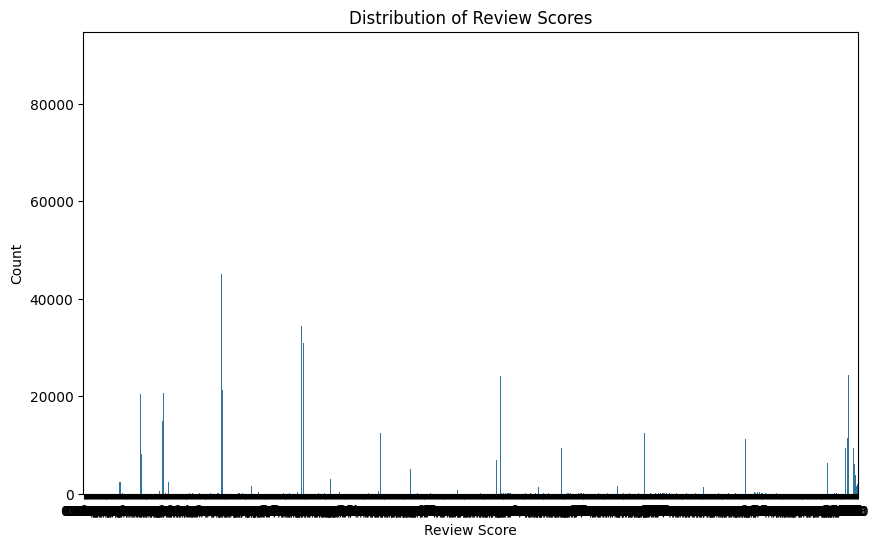

In [ ]:
# Visualize the distribution of review scores using a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='review_score', data=df_cleaned, order=sorted_scores)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

We can see a wide range in review scores

#### 3.1.4 Categorizing Review Scores

By identifying common rating formats, such as integers, letter grades, and numeric fractions, this approach aims to systematically categorize inconsistent review scores. These patterns guarantee that the dataset can be standardized and cleaned for analysis. Entering unclear or invalid data, like combining decimals and fractions, is marked as an error. This technique makes the dataset more consistent, which improves interpretation and precision in further analysis.

In [ ]:
def categorize_score(score):
    if re.match(r'^\d+/\d+$', score):  # Matches numeric fractions (e.g., 3/5)
        return "Fraction"
    elif re.match(r'^\d+$', score):  # Matches integers (e.g., 100, 5)
        return "Integer"
    elif re.match(r'^[A-F][+-]?$', score):  # Matches letter grades (e.g., A, B+)
        return "Letter Grade"
    elif re.match(r'^\d+/\d+\.\d+$', score):  # Flags mixed fractions with decimals as errors
        return "Error"
    else:
        return "Other"

# Apply the categorization
df_cleaned['score_category'] = df_cleaned['review_score'].apply(categorize_score)

# Count the occurrences of each category
category_counts = df_cleaned['score_category'].value_counts()
print(category_counts)

score_category
Fraction        504773
Other           188784
Letter Grade    128918
Integer           1598
Error                8
Name: count, dtype: int64


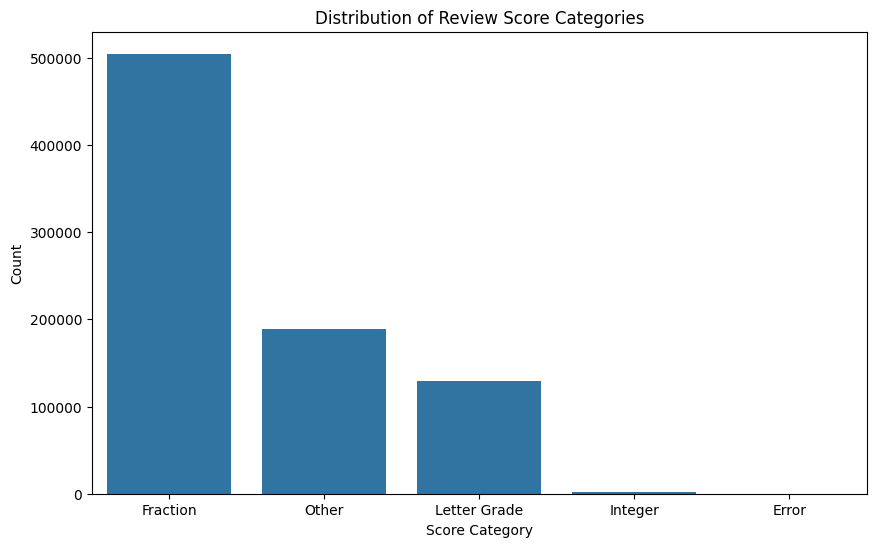

In [ ]:
# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(x='score_category', data=df_cleaned, order=category_counts.index)
plt.title('Distribution of Review Score Categories')
plt.xlabel('Score Category')
plt.ylabel('Count')
plt.show()

In [ ]:
# View some examples from each category to verify correctness
for category in ['Fraction', 'Integer', 'Letter Grade', 'Error', 'Other']:
    print(f"\nExamples from {category} category:")
    print(df_cleaned[df_cleaned['score_category'] == category]['review_score'].head())


Examples from Fraction category:
6     1/4
9     3/5
10    4/5
11    2/4
12    2/5
Name: review_score, dtype: object

Examples from Integer category:
20149    5
25348    4
36832    7
37083    5
37917    5
Name: review_score, dtype: object

Examples from Letter Grade category:
8      B
14     C
18     B
32    C-
37    B-
Name: review_score, dtype: object

Examples from Error category:
448354    4/5.5
453642    4/3.5
607743    4/3.5
775214    3/5.5
775218    3/5.5
Name: review_score, dtype: object

Examples from Other category:
3     3.5/5
7     3.5/5
15    3.5/5
17    2.5/4
20    2.5/4
Name: review_score, dtype: object


The findings show that the categorization function worked as intended, successfully classifying review scores into distinct categories.

->Fraction Category: Successfully captured valid numeric fractions such as "1/4" and "3/5."

->Integer Category: Correctly classified whole numbers like "5" and "7."

->Letter Grade Category: Included letter-based scores like "B" and "C-" as intended.

->Error Category: Flagged mixed fractions with decimals (e.g., "4/5.5") as data entry errors for further review.

->Other Category: Contains ratings like "3.5/5" that may represent decimal fractions, requiring further inspection or re-categorization.


Accurate interpretation of specifc score categories is difficult without knowledge of the rating scale; therefore, more data or standardization are required.

->Error Category: The mixed fractions with decimals, such as "4/5.5," indicate a rating scale that is unclear or inconsistent, likely resulting from data entry errors. These should be reviewed or removed to avoid misleading conclusions.

-> Integer Category: Although these entries are valid integers, they lack context regarding the scale (e.g., is "5" out of 5, 10, or 100?). Without knowing the rating scale, it is challenging to interpret these scores accurately, and additional information or standardization is needed.

Removing Error and Integer Categories

In order to guarantee data consistency and accuracy, it makes sense to eliminate these ambiguous entries because the Integer and Error categories only comprise 1,606 entries out of a much larger dataset.

In [ ]:
# Filter out ambiguous entries in 'Integer' and 'Error' categories
df_cleaned = df_cleaned[~df_cleaned['score_category'].isin(['Integer', 'Error'])]

In [ ]:
# Recalculate value counts for the score categories after removing ambiguous entries
category_counts_cleaned = df_cleaned['score_category'].value_counts()

# Display the updated distribution
print(category_counts_cleaned)

score_category
Fraction        504773
Other           188784
Letter Grade    128918
Name: count, dtype: int64


In [ ]:
# Display the total number of entries in the cleaned DataFrame
total_entries = df_cleaned.shape[0]
print(f"Total number of entries in cleaned DataFrame: {total_entries}")


Total number of entries in cleaned DataFrame: 822475


#### 3.1.5 Normalizing Review Scores

The objective of the following method is to improve comparability by standardizing review scores from different formats into a uniform 1–5 scale. By dividing the numerator by the denominator and scaling the result to 5, it manages fraction scores. The function converts integer scores to the 1–5 range by assuming either 10 or 100 as the scale. Not only are mixed fractions normalized in a manner similar to that of regular fractions, but letter grades are mapped to corresponding values on the same scale ('A' equals 5). The function maintains consistency across various rating types by making sure that no score is lower than 1.

In [ ]:
def normalize_score_to_1_5(score):
    normalized = None  # Initialize normalized with None

    # Normalize fraction scores (e.g., 3/5, 85/100, 3.5/5)
    if re.match(r'^\d+(\.\d+)?/\d+(\.\d+)?$', score):
        num, denom = map(float, score.split('/'))
        if denom != 0:
            normalized = (num / denom) * 5

    # Normalize integer scores (e.g., 5, 100)
    elif re.match(r'^\d+$', score):
        score = int(score)
        if score <= 10:  # Assume scale is out of 10
            normalized = score / 2  # Scale directly to 5
        elif score <= 100:  # Assume scale is out of 100
            normalized = score / 20  # Scale directly to 5

    # Normalize letter grades (A-F scale)
    elif re.match(r'^[A-F][+-]?$', score):
        grade_mapping = {
            'A': 5.0, 'A-': 4.7, 'B+': 4.3, 'B': 4.0, 'B-': 3.7,
            'C+': 3.3, 'C': 3.0, 'C-': 2.7, 'D+': 2.3, 'D': 2.0,
            'D-': 1.5, 'F': 1.0
        }
        normalized = grade_mapping.get(score, 1.0)

    # Handle mixed fractions and other unusual formats
    elif re.match(r'^\d+/\d+\.\d+$', score):
        num, denom = score.split('/')
        denom = float(denom)
        if denom != 0:
            normalized = (float(num) / denom) * 5

    # Ensure normalized is not None and cap at 1 if necessary
    if normalized is not None and normalized < 1:
        normalized = 1

    return normalized

# Apply the normalization function
df_cleaned['normalized_score'] = df_cleaned['review_score'].apply(normalize_score_to_1_5)

Checking for missing values

In [ ]:
missing_normalized_scores = df_cleaned['normalized_score'].isnull().sum()
print(f"Number of missing normalized scores: {missing_normalized_scores}")

Number of missing normalized scores: 6


Dropping missing values

In [ ]:
# Drop rows with missing 'normalized_score'
df_cleaned = df_cleaned.dropna(subset=['normalized_score'])

Ensuring correct range

In [ ]:
min_score = df_cleaned['normalized_score'].min()
max_score = df_cleaned['normalized_score'].max()

print(f"Range of normalized scores: {min_score} to {max_score}")

Range of normalized scores: 1.0 to 45.0


Examining scores exceeding 5

In [ ]:
# Filter and count all scores that exceed 5
exceeding_scores = df_cleaned[df_cleaned['normalized_score'] > 5]
exceeding_count = exceeding_scores.shape[0]

# Display the rows with scores exceeding 5 and count
print(exceeding_scores[['review_score', 'normalized_score']])


        review_score  normalized_score
44843            7/5          7.000000
111377         4.5/4          5.625000
112814         5.5/5          5.500000
126588           9/5          9.000000
152047         3.5/3          5.833333
190365           8/5          8.000000
201589         9.5/5          9.500000
202512         5.5/5          5.500000
238191          35/4         43.750000
238833           9/5          9.000000
336986         5.5/5          5.500000
359236          35/4         43.750000
379580         5.5/5          5.500000
462329         5.5/5          5.500000
490080         4.5/4          5.625000
503524         4.5/4          5.625000
556085         67/10         33.500000
565895         87/10         43.500000
646755         8.5/5          8.500000
669936          35/4         43.750000
669954          35/4         43.750000
680317         5.5/5          5.500000
680334         5.5/5          5.500000
682808         4.5/4          5.625000
682817         4.5/4     

In [ ]:
print(f"Number of scores exceeding 5: {exceeding_count}")

Number of scores exceeding 5: 42


Dropping scores exceeding 5

In [ ]:
# Drop rows where normalized_score exceeds 5
df_cleaned = df_cleaned[df_cleaned['normalized_score'] <= 5]


Confirming correct range

In [ ]:
min_score = df_cleaned['normalized_score'].min()
max_score = df_cleaned['normalized_score'].max()

print(f"Range of normalized scores: {min_score} to {max_score}")

Range of normalized scores: 1.0 to 5.0


Investigating descpritive statistics

In [ ]:
df_cleaned["normalized_score"].describe()

,normalized_score
count,822427.000000
mean,3.244418
std,1.029908
min,1.000000
25%,2.500000
50%,3.300000
75%,4.000000
max,5.000000


There are 822,427 successfully normalized review scores in the dataset; the scores range from 1 to 5. The standard deviation of 1.03 indicates a moderate spread around the mean, while the average score of 3.24 indicates a slight skew towards higher ratings. With 25% of scores below 2.5 and 75% below 4, the median score is 3.3. The fact that the data is evenly distributed within the anticipated range of 1–5 indicates that the normalization procedure was successful in producing a scale that is reliable for analysis.

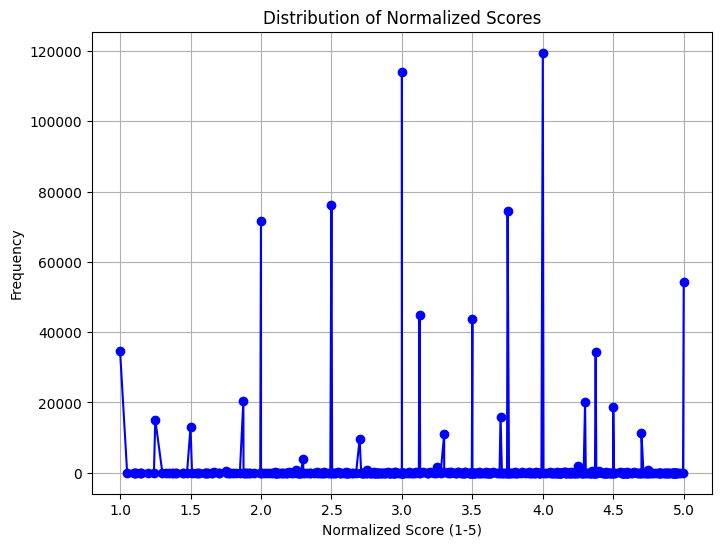

In [ ]:
# Plot the distribution of normalized scores as a line graph
plt.figure(figsize=(8, 6))
# Calculate the frequency of each score and plot it as a line
df_cleaned['normalized_score'].value_counts().sort_index().plot(kind='line', marker='o', linestyle='-', color='blue')
plt.title('Distribution of Normalized Scores')
plt.xlabel('Normalized Score (1-5)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The line graph clearly demonstrates the preference of reviewers for rounded scores at whole number ratings of 2.0, 3.0, and 4.0. Although less common, half-point ratings such as 2.5, 3.5, and 4.5 are also common. Very few ratings are at non-standard decimal values, such as 1.1 or 2.8, and compared to mid-range scores, extreme ratings (1.0 and 5.0) are less common. Overall, the data points to a significant preference among reviewers for more straightforward, traditional rating scales.

It makes sense to bucketize the rating scores into 1, 2, 3, 4, and 5 categories in light of the observed distribution and the evident preference for full ratings. This strategy minimizes the occurrence of more precise decimal values by aligning with the natural clustering of the data, where reviewers typically assign whole-number or half-point scores.

#### 3.1.6 Analyzing Normalized Score

Confirming correct range

In [ ]:
min_score = df_cleaned['normalized_score'].min()
max_score = df_cleaned['normalized_score'].max()

print(f"Range of normalized scores: {min_score} to {max_score}")

Range of normalized scores: 1.0 to 5.0


Investigating descpritive statistics

In [ ]:
df_cleaned["normalized_score"].describe()

,normalized_score
count,757062.000000
mean,3.263031
std,1.023640
min,1.000000
25%,2.500000
50%,3.300000
75%,4.000000
max,5.000000


There are 822,427 successfully normalized review scores in the dataset; the scores range from 1 to 5. The standard deviation of 1.03 indicates a moderate spread around the mean, while the average score of 3.24 indicates a slight skew towards higher ratings. With 25% of scores below 2.5 and 75% below 4, the median score is 3.3. The fact that the data is evenly distributed within the anticipated range of 1–5 indicates that the normalization procedure was successful in producing a scale that is reliable for analysis.

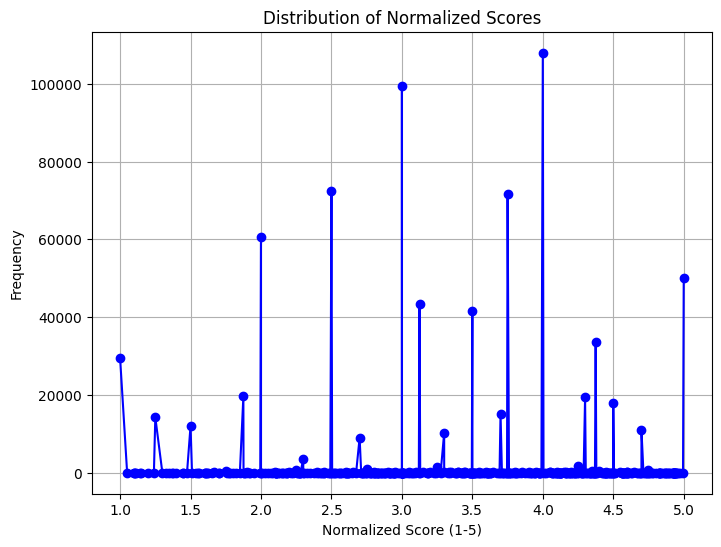

In [ ]:
# Plot the distribution of normalized scores as a line graph
plt.figure(figsize=(8, 6))
# Calculate the frequency of each score and plot it as a line
df_cleaned['normalized_score'].value_counts().sort_index().plot(kind='line', marker='o', linestyle='-', color='blue')
plt.title('Distribution of Normalized Scores')
plt.xlabel('Normalized Score (1-5)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Calculate Spearman Correlation between Rating Sentiment Polarity and Bucketed Score
spearman_corr_rating, spearman_pval_rating = spearmanr(df_cleaned['rating_sentiment_polarity'], df_cleaned['normalized_score'])

# Output the correlation result
print(f"\nSpearman correlation (Rating): {spearman_corr_rating}, p-value: {spearman_pval_rating}")


Spearman correlation (Rating): 0.5148627590073492, p-value: 0.0


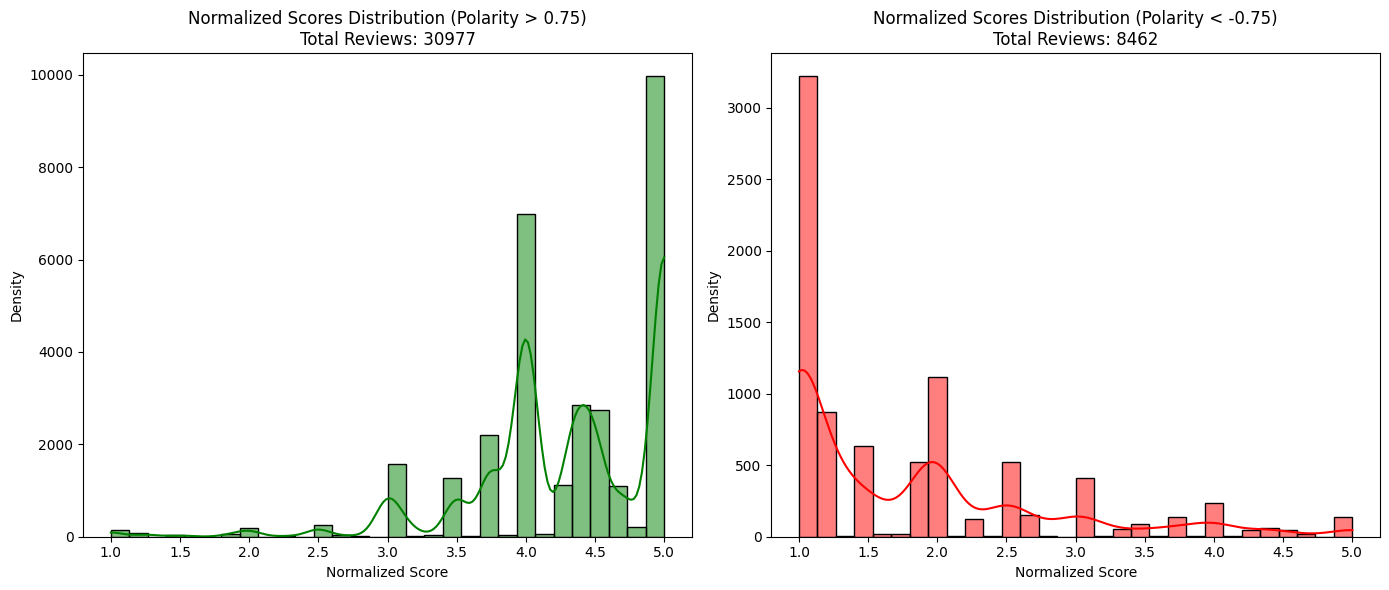

In [ ]:
# Filter Reviews with Sentiment Polarity > 0.75 and < -0.75
higher_than_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] > 0.75]
smaller_than_minus_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] < -0.75]

# Plot the distribution of normalized scores with KDE for reviews with polarity > 0.75 and < -0.75
plt.figure(figsize=(14, 6))

# KDE plot for normalized scores with polarity > 0.75
plt.subplot(1, 2, 1)
sns.histplot(higher_than_075_rating['normalized_score'], kde=True, color='green', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity > 0.75)\nTotal Reviews: {higher_than_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

# KDE plot for normalized scores with polarity < -0.75
plt.subplot(1, 2, 2)
sns.histplot(smaller_than_minus_075_rating['normalized_score'], kde=True, color='red', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity < -0.75)\nTotal Reviews: {smaller_than_minus_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

These plots support the idea that high positive polarity strongly correlates with ratings near the maximum score (4.0-5.0), while high negative polarity correlates with the minimum scores (1.0-2.0).

This distribution is also appropriate for a regression model as it provides more nuanced insight into how sentiment affects score variation across the entire spectrum, rather than discrete categories.

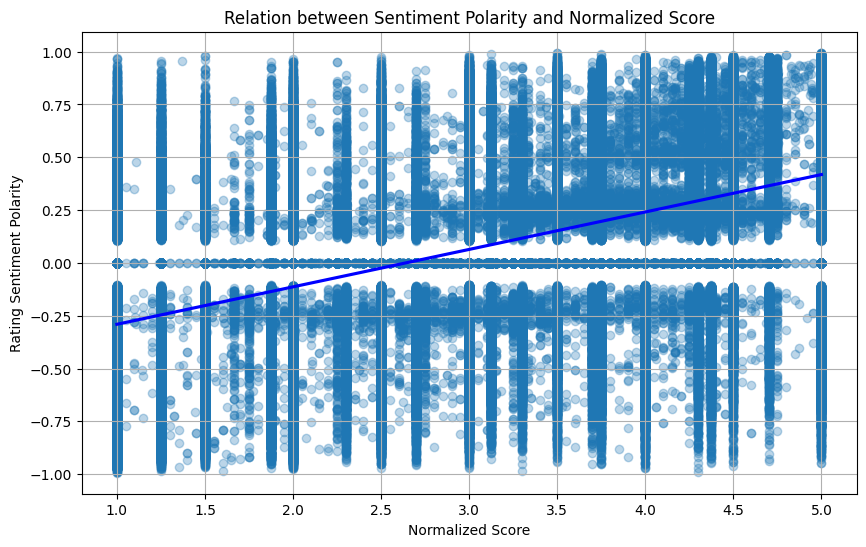

Number of outliers: 30427
                                           review_content  normalized_score  \
272     As fabulous and fantastic as anything he has e...          3.500000   
1863    Economic repression by competitive market forc...          3.500000   
2106    Amazing Grace marks an unforgettable and regre...          3.500000   
2444           As ridiculous as it is uproariously funny.          3.500000   
5918    One of the grimmest end-of-the-world movies in...          3.500000   
...                                                   ...               ...   
348146  Contrived and somewhat dull, but the talented ...          3.505000   
251980  Often contrived, stilted and awkwardly preachy...          2.725000   
417508  Solid performances can't save the film from it...          2.725000   
735238  An enchanting, provocative, bighearted story t...          4.095000   
677891  It's not that The Science of Sleep is a terrib...          2.272727   

        rating_sentiment_

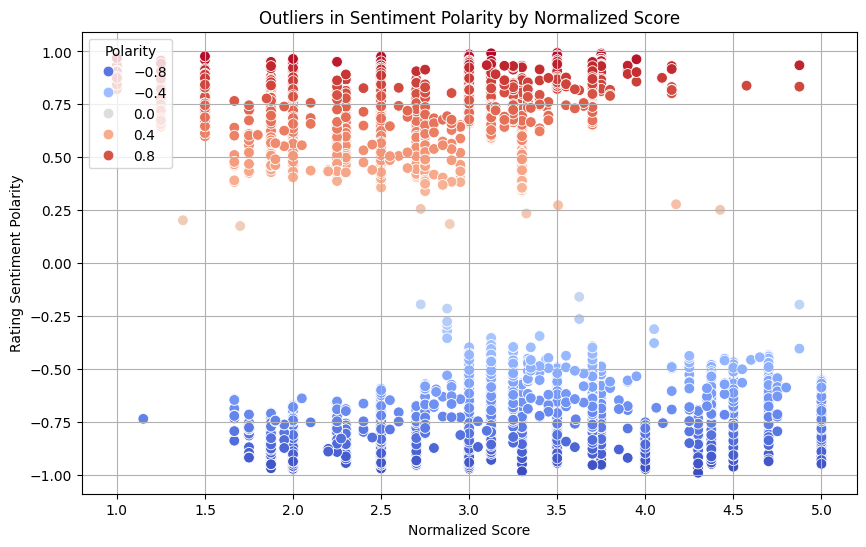

In [ ]:
# Define the function to identify outliers
def identify_outliers(df, column, score_column):
    outliers = pd.DataFrame()
    for score in df[score_column].unique():
        score_data = df[df[score_column] == score]
        Q1 = score_data[column].quantile(0.25)
        Q3 = score_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_in_score = score_data[(score_data[column] < lower_bound) | (score_data[column] > upper_bound)]
        outliers = pd.concat([outliers, outliers_in_score])
    return outliers

# Scatter plot with regression line for continuous relation
plt.figure(figsize=(10, 6))
sns.regplot(x='normalized_score', y='rating_sentiment_polarity', data=df_cleaned, scatter_kws={'alpha':0.3}, line_kws={'color': 'blue'})
plt.title('Relation between Sentiment Polarity and Normalized Score')
plt.xlabel('Normalized Score')
plt.ylabel('Rating Sentiment Polarity')
plt.grid(True)
plt.show()

# Perform outlier analysis using the defined function
outliers = identify_outliers(df_cleaned, 'rating_sentiment_polarity', 'normalized_score')
outliers_selected_columns = outliers[['review_content', 'normalized_score', 'rating_sentiment_polarity']]
print("Number of outliers:", len(outliers_selected_columns))
print(outliers_selected_columns)

# Scatter plot for outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_score', y='rating_sentiment_polarity', data=outliers, hue='rating_sentiment_polarity', palette='coolwarm', edgecolor='w', s=60)
plt.title('Outliers in Sentiment Polarity by Normalized Score')
plt.xlabel('Normalized Score')
plt.ylabel('Rating Sentiment Polarity')
plt.legend(title='Polarity', loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Filtering for Extreme Positive Sentiment with Low Ratings
extreme_positive_low_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] > 0.75) &
    (df_cleaned['normalized_score'] <= 3)
]

# Filtering for Extreme Negative Sentiment with High Ratings
extreme_negative_high_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] < -0.75) &
    (df_cleaned['normalized_score'] >= 3)
]

# Displaying the outliers for extreme positive sentiment with low ratings
print("Extreme Positive Sentiment with Low Ratings (Sample):")
print(extreme_positive_low_rating[['review_content', 'normalized_score', 'rating_sentiment_polarity']].head(10))

# Displaying the outliers for extreme negative sentiment with high ratings
print("\nExtreme Negative Sentiment with High Ratings (Sample):")
print(extreme_negative_high_rating[['review_content', 'normalized_score', 'rating_sentiment_polarity']].head(10))


Extreme Positive Sentiment with Low Ratings (Sample):
                                         review_content  normalized_score  \
189   Real joys and sorrows must be bigger and deepe...             2.500   
282   Roland Emmerich has a remarkable talent for dr...             1.500   
307   The best acting comes from woolly mammoths, ma...             1.250   
397           A remarkably beautiful yet soulless film.             1.875   
1266  Pierce Brosnan oferece, aqui, um dos melhores ...             3.000   
1326  This crude, inspirational tear-jerker is as sw...             1.000   
1847                    ...gorgeously-shot, melancholy.             3.000   
2089  An inspirational, moving and wonderfully well-...             3.000   
2333  The most impressive thing about Interview is h...             2.500   
2831  A splendidly mounted and visually imaginative ...             3.000   

      rating_sentiment_polarity  
189                    0.862460  
282                    0.75581


This approach systematically identifies and quantifies outliers that exhibit a discrepancy between sentiment polarity and normalized score, specifically targeting instances where extremely positive sentiment corresponds to low ratings and extremely negative sentiment aligns with high ratings. By filtering for cases where high sentiment polarity (> 0.75) is paired with low scores (<= 3), and low sentiment polarity (< -0.75) is paired with high scores (>= 3), the analysis captures reviews in which the expected relationship between sentiment and rating is inverted. This method facilitates an understanding of instances where the sentiment analysis may diverge from the reviewer’s assigned rating, potentially due to factors such as sarcasm, mixed sentiments, or nuanced expressions of opinion.

In [ ]:
# Filtering for Extreme Positive Sentiment with Low Ratings
extreme_positive_low_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] > 0.75) &
    (df_cleaned['normalized_score'] <= 3)
]

# Filtering for Extreme Negative Sentiment with High Ratings
extreme_negative_high_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] < -0.75) &
    (df_cleaned['normalized_score'] >= 3)
]

# Counting the number of outliers in each category
count_extreme_positive_low_rating = extreme_positive_low_rating.shape[0]
count_extreme_negative_high_rating = extreme_negative_high_rating.shape[0]

# Displaying the counts
print("Count of Extreme Positive Sentiment with Low Ratings:")
print(count_extreme_positive_low_rating)
print()
print("Count of Extreme Negative Sentiment with High Ratings:"  )
print(count_extreme_negative_high_rating)


Count of Extreme Positive Sentiment with Low Ratings:
2061

Count of Extreme Negative Sentiment with High Ratings:
1242


The counts reveal that there are 784 instances of extreme positive sentiment paired with low ratings and 779 instances of extreme negative sentiment associated with high ratings. This indicates a roughly balanced presence of such outliers in the dataset.


In [ ]:
# Verifying the new dataset size before removing the outliers
df_cleaned.shape

(757062, 17)

In [ ]:
# Dropping the identified outliers from the dataset
df_cleaned = df_cleaned.drop(extreme_positive_low_rating.index)
df_cleaned = df_cleaned.drop(extreme_negative_high_rating.index)

# Verifying the new dataset size after removing the outliers
df_cleaned.shape

(753759, 17)

The decision to exclude these outliers from the dataset is based on their atypical relationship between sentiment polarity and normalized score. Instances where highly positive sentiment is paired with low ratings, and highly negative sentiment with high ratings, represent a divergence from the expected correlation, potentially due to factors such as sarcasm, mixed sentiments, or inconsistencies in sentiment detection. By removing these cases, the analysis aims to reduce noise and enhance the model's ability to learn from more consistent data patterns, thereby improving the reliability and validity of predictive outcomes in subsequent analyses.

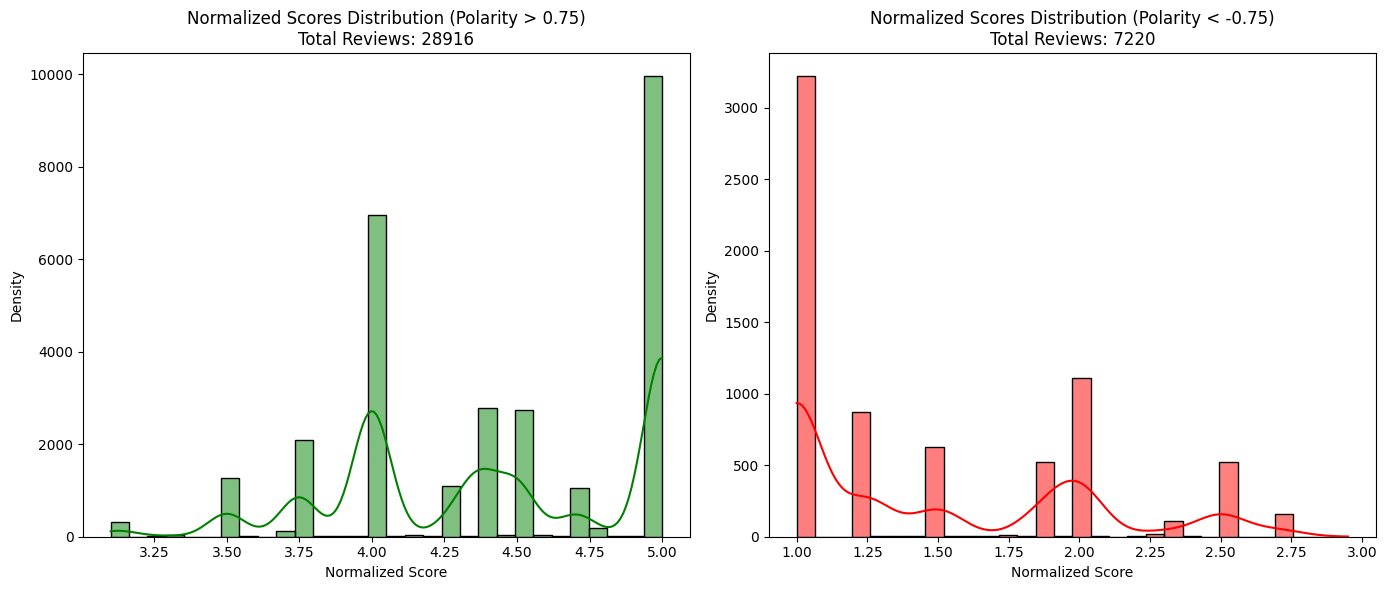

In [ ]:
# Filter Reviews with Sentiment Polarity > 0.75 and < -0.75
higher_than_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] > 0.75]
smaller_than_minus_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] < -0.75]

# Plot the distribution of normalized scores with KDE for reviews with polarity > 0.75 and < -0.75
plt.figure(figsize=(14, 6))

# KDE plot for normalized scores with polarity > 0.75
plt.subplot(1, 2, 1)
sns.histplot(higher_than_075_rating['normalized_score'], kde=True, color='green', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity > 0.75)\nTotal Reviews: {higher_than_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

# KDE plot for normalized scores with polarity < -0.75
plt.subplot(1, 2, 2)
sns.histplot(smaller_than_minus_075_rating['normalized_score'], kde=True, color='red', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity < -0.75)\nTotal Reviews: {smaller_than_minus_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Removing the outliers has reduced the discrepancies, leading to a distribution that better reflects the correlation between sentiment polarity and normalized score. This should help the model to learn more effectively from the data, as it now represents a more straightforward relationship between sentiment and rating. Great work on refining the dataset!

## Checking for Missing Values

In [ ]:
df_cleaned.columns

Index(['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name',
       'review_type', 'review_score', 'review_date', 'review_content',
       'score_category', 'normalized_score', 'rounded_score', 'bucketed_score',
       'word_count', 'vader_sentiment_polarity', 'twitter_sentiment_polarity',
       'financial_sentiment_polarity', 'rating_sentiment_polarity'],
      dtype='object')

In [ ]:
# Checking for missing values in all columns of the dataset
missing_values_all = df_cleaned.isnull().sum()
print(missing_values_all)

rotten_tomatoes_link               0
critic_name                     5931
top_critic                         0
publisher_name                     0
review_type                        0
review_score                       0
review_date                        0
review_content                     0
score_category                     0
normalized_score                   0
rounded_score                      0
bucketed_score                     0
word_count                         0
vader_sentiment_polarity           0
twitter_sentiment_polarity         0
financial_sentiment_polarity       0
rating_sentiment_polarity          0
dtype: int64


Identifyed missing values in top_critic so further analyzing those.

In [ ]:
# Filtering the dataset for rows with missing 'critic_name'
missing_critic_name_df = df_cleaned[df_cleaned['critic_name'].isnull()]

# Checking the distribution of 'normalized_score' for rows with missing 'critic_name'
rating_distribution_missing_critic = missing_critic_name_df['normalized_score'].value_counts().sort_index()

# Display the rating distribution
print(rating_distribution_missing_critic)

normalized_score
1.000000    262
1.250000    104
1.500000     27
1.666667      7
1.875000    107
2.000000    589
2.300000      4
2.500000    357
2.600000      1
2.700000     98
3.000000    812
3.125000    335
3.250000      3
3.300000     75
3.333333      5
3.500000    117
3.700000    142
3.750000    528
4.000000    843
4.166667      1
4.200000      1
4.300000    163
4.350000      1
4.375000    393
4.500000    140
4.583333      1
4.700000     89
5.000000    726
Name: count, dtype: int64



As the critic_name feature is not essential to the analysis, entries with missing values in this column will be retained to preserve the dataset's overall sample size. This approach ensures that potentially valuable data from other features remains intact, thereby maximizing the dataset's utility for analysis without compromising the results.

## Export

All columns that will not be required in the modeling phase of the project are being removed

In [ ]:
# Drop all other sentiment polarity columns except 'rating_sentiment_polarity'
columns_to_drop = ['twitter_sentiment_polarity', 'vader_sentiment_polarity', 'financial_sentiment_polarity', 'score_category', 'review_score', 'bucketed_score', 'rounded_score']
df_cleaned = df_cleaned.drop(columns=columns_to_drop, errors='ignore')

Renaming to sentiment polarity and rating

In [ ]:
# Rename 'rating_sentiment_polarity' to 'sentiment_polarity'
df_cleaned = df_cleaned.rename(columns={'rating_sentiment_polarity': 'sentiment_polarity'})

df_cleaned = df_cleaned.rename(columns={'normalized_score': 'rating'})

In [ ]:
df_cleaned

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_date,review_content,rating,word_count,sentiment_polarity
0,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,2010-02-09,Whether audiences will get behind The Lightnin...,3.50,37,0.000000
1,m/0814255,Nick Schager,False,Slant Magazine,Rotten,2010-02-10,Harry Potter knockoffs don't come more transpa...,1.25,17,-0.410805
2,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,2010-02-10,"Percy Jackson isn't a great movie, but it's a ...",3.50,23,0.253021
3,m/0814255,Jordan Hoffman,False,UGO,Fresh,2010-02-10,"Fun, brisk and imaginative",4.00,4,0.231060
4,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,2010-02-10,"Crammed with dragons, set-destroying fights an...",3.00,30,-0.149372
...,...,...,...,...,...,...,...,...,...,...
757057,m/zulu,NaN,False,Empire Magazine,Fresh,2017-07-10,As a spectacular war film with a powerful mora...,4.00,10,0.768415
757058,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,2007-03-07,"Seen today, it's not only a startling indictme...",3.50,18,0.246188
757059,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,2010-09-16,A rousing visual spectacle that's a prequel of...,4.30,14,-0.175630
757060,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,2011-02-28,"A simple two-act story: Prelude to war, and th...",3.50,45,0.000000


In [ ]:
output_file_path = '/content/drive/My Drive/Work Project/Data/Rotten Tomatoes/archive/df_modeling_regression.csv'

df_cleaned.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

DataFrame saved to /content/drive/My Drive/Work Project/Data/Rotten Tomatoes/archive/df_modeling_regression.csv


#### 3.1.6 Bucketizing Review Scores

In order to frame the rating prediction problem as a classification task rather than a regression task, this approach attempts to classify the normalized scores into discrete "buckets". BERT and other trained NLP models have proven to perform exceptionally well in text classification tasks, which makes this setup especially useful for rating category prediction. The model can concentrate on predicting particular classes by converting continuous scores into predefined buckets. This frequently leads to better performance, particularly when working with textual data.

##### 3.1.6.1 Up Rounding

When bucketizing, the rationale for rounding up scores is to make sure that values that are on the borderline or midway—such as 3.5—are assigned to the higher rating bucket. This method effectively moves films with marginally higher-than-average ratings into higher categories by creating a more optimistic grouping of scores. Rounding up prevents underrepresenting films that are closer to a higher rating, which can be helpful when attempting to simplify scores for classification tasks. Rounding up also better captures the intent of the rating.

Distribution of reviews across buckets with up rounding:
bucketed_score
1     49809
2    187293
3    185053
4    333158
5     67114
Name: count, dtype: int64


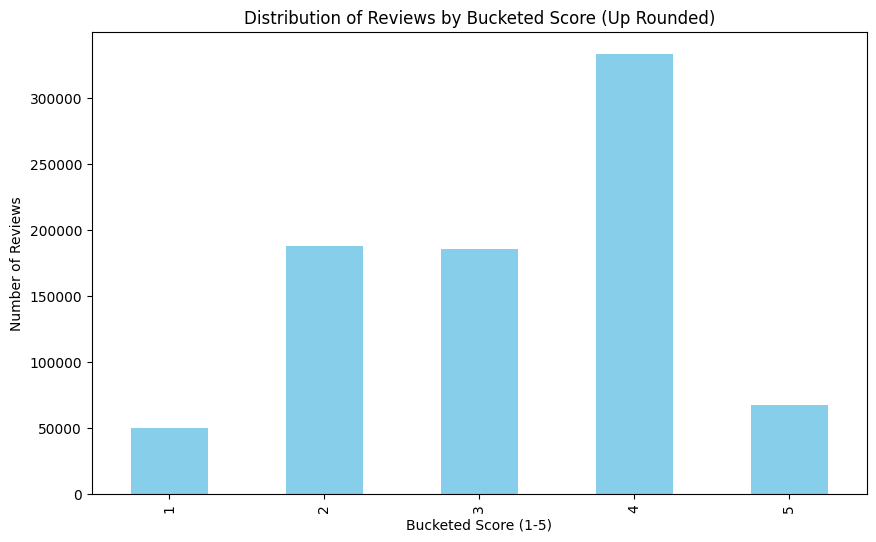

In [ ]:
# Round the normalized scores to the nearest integer
df_cleaned['rounded_score'] = df_cleaned['normalized_score'].round()

# Define bucket edges
bins = [1, 2, 3, 4, 5, 6]  # Same bin edges as before, but now using rounded values
labels = [1, 2, 3, 4, 5]

# Assign each rounded score to a bucket
df_cleaned['bucketed_score'] = pd.cut(df_cleaned['rounded_score'], bins=bins, labels=labels, include_lowest=True, right=False)

# Check the distribution across buckets
bucket_distribution = df_cleaned['bucketed_score'].value_counts().sort_index()
print("Distribution of reviews across buckets with up rounding:")
print(bucket_distribution)

# Plot the bucket distribution
plt.figure(figsize=(10, 6))
bucket_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Reviews by Bucketed Score (Up Rounded)')
plt.xlabel('Bucketed Score (1-5)')
plt.ylabel('Number of Reviews')
plt.show()


The distribution of reviews across the five buckets reveals an interesting pattern. Bucket 4 has the highest concentration of reviews, with 333,158 entries, significantly higher than the other buckets. Bucket 2 and 3 are more balanced, with 187,293 and 185,053 reviews, respectively, showing that a large number of reviews fall within a middle range. Bucket 1 has the fewest reviews, at 49,809, followed by bucket 5, with 67,114 reviews. This distribution suggests that reviews tend to cluster around the middle-to-high range, with fewer extremely low or extremely high ratings.

##### 3.1.6.2 Floor Rounding


When bucketizing scores, the rationale behind floor rounding is to assign mid-point values—such as 3.5—to the bucket with the lower rating. With this method, borderline scores are grouped in a way that doesn't artificially inflate the rating, ensuring a more conservative grouping. When avoiding overestimation is crucial for analysis or classification tasks, floor rounding can help maintain a stricter interpretation of the ratings by more carefully capturing the score's intent.

Distribution of reviews across buckets with floor rounding:
bucketed_score
1     84225
2    164370
3    309595
4    209887
5     54350
Name: count, dtype: int64


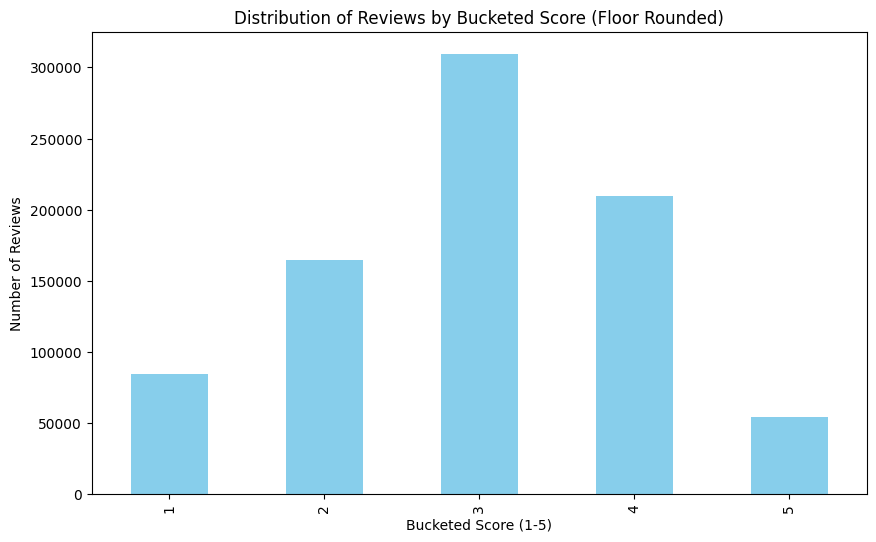

In [ ]:
# Define bucket edges
bins = [1, 2, 3, 4, 5, 6]  # Note that we include 6 to cover the upper edge of the last interval
labels = [1, 2, 3, 4, 5]

# Assign each normalized score to a bucket
df_cleaned['bucketed_score'] = pd.cut(df_cleaned['normalized_score'], bins=bins, labels=labels, include_lowest=True, right=False)

# Check the distribution across buckets
bucket_distribution = df_cleaned['bucketed_score'].value_counts().sort_index()
print("Distribution of reviews across buckets with floor rounding:")
print(bucket_distribution)

plt.figure(figsize=(10, 6))
bucket_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Reviews by Bucketed Score (Floor Rounded)')
plt.xlabel('Bucketed Score (1-5)')
plt.ylabel('Number of Reviews')
plt.show()

Compared to the earlier findings with up rounding, the distribution of reviews across buckets with floor rounding is noticeably different. Floor rounding results in a more evenly distributed distribution among the middle buckets; bucket 3 has the highest number of reviews (309,595), followed by bucket 4 (209,887). Bucket 1, on the other hand, has a lot more reviews (84,225) than it did before up rounding. This change implies that floor rounding tends to push more scores into the lower buckets, especially into bucket 3 instead of bucket 4, especially for borderline scores (like 3.5). As a result, the classification becomes more conservative and the ratings are distributed more fairly among mid-range categories. Regardless of the rounding technique, bucket 5 continues to be the smallest, reflecting the relative rarity of the highest ratings.

### 3.2 Review Content

#### 3.1 Missing Values

In [ ]:
# Print the number of rows before dropping missing values
initial_row_count = df_cleaned.shape[0]
print(f"Number of rows before dropping missing values: {initial_row_count}")

Number of rows before dropping missing values: 822427


In [ ]:
# Check for missing values in the 'review_content' column
missing_review_content = df_cleaned['review_content'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'review_content': {missing_review_content}")

Number of missing values in 'review_content': 65365


In [ ]:
# Drop rows with missing values in 'review_content'
df_cleaned = df_cleaned.dropna(subset=['review_content'])

# Print the number of rows after dropping missing values
final_row_count = df_cleaned.shape[0]
print(f"Number of rows after dropping missing values: {final_row_count}")

Number of rows after dropping missing values: 757062


The dataset was reduced from 822,427 to 757,062 rows by removing rows with missing values in the "review_content" column in order to assure the integrity of the analysis. For tasks like sentiment analysis and text classification, the review text is essential, so missing or incomplete content could distort the results or cause errors. By eliminating these rows, we are able to keep a consistent and trustworthy dataset in which all reviews have the text needed for additional investigation. This guarantees that the data used for upcoming analyses and models is accurate and comprehensive.

#### 3.2 Word Count

When evaluating the predictive models' accuracy, word count analysis is essential, particularly when considering review duration. The performance of a model can be affected by the length of the reviews; longer reviews typically provide more detail and nuance, while shorter reviews might contain less contextual information. We can gain more insight into how review length affects the model's predictive accuracy of ratings by looking at the word count distribution.

Word Count Statistics:
count    757062.000000
mean         21.196502
std           9.415894
min           1.000000
25%          14.000000
50%          21.000000
75%          28.000000
max          55.000000
Name: word_count, dtype: float64


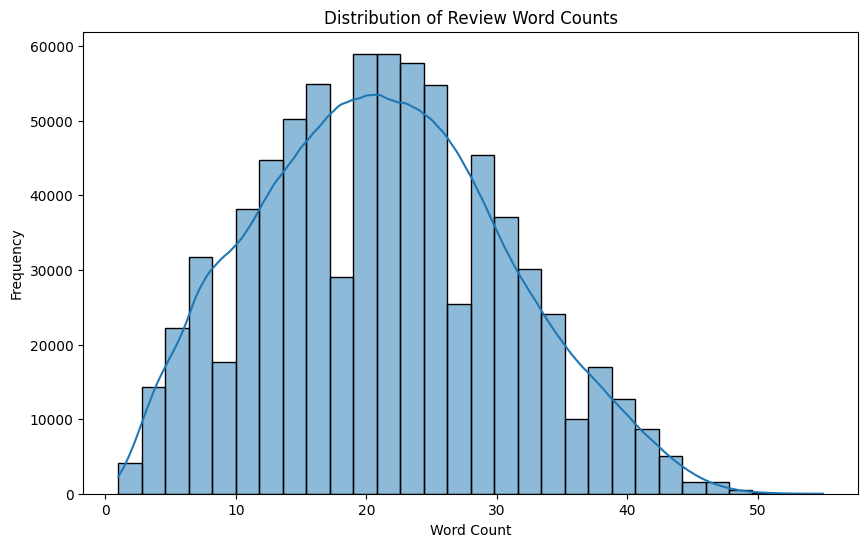

In [ ]:
# Calculate the word count for each review
df_cleaned['word_count'] = df_cleaned['review_content'].apply(lambda x: len(str(x).split()))

# Display basic statistics about word count
word_count_stats = df_cleaned['word_count'].describe()
print("Word Count Statistics:")
print(word_count_stats)

# Visualize the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['word_count'], bins=30, kde=True)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


With a standard deviation of roughly 9.42 and an average word count of about 21, the word count analysis indicates a moderate range in review length. The shortest review consists of just 1 word, while the longest has 55 words. Seventy-five percent of reviews are 28 words or less, while a quarter of reviews are 14 words or less. The median review length is 21 words. This indicates that only a small percentage of reviews are more detailed, and the majority are generally brief.

In [ ]:
# Filter out reviews shorter than 10 words
filtered_df = df_cleaned[df_cleaned['word_count'] >= 10]

# Count the number of remaining reviews
remaining_count = len(filtered_df)

print(f"Number of reviews with 10 or more words: {remaining_count}")

Number of reviews with 10 or more words: 667042


### 3.3 Word Count Data Subsets

Create subsets of reviews based on different length ranges (0-10, 10-20, 20-30, 30+)

In [ ]:
# Filter reviews by word count ranges
subset_0_10 = df_cleaned[df_cleaned['word_count'] < 10]
subset_10_20 = df_cleaned[(df_cleaned['word_count'] >= 10) & (df_cleaned['word_count'] < 20)]
subset_20_30 = df_cleaned[(df_cleaned['word_count'] >= 20) & (df_cleaned['word_count'] < 30)]
subset_30_plus = df_cleaned[df_cleaned['word_count'] >= 30]

# Count the number of reviews in each subset
count_0_10 = len(subset_0_10)
count_10_20 = len(subset_10_20)
count_20_30 = len(subset_20_30)
count_30_plus = len(subset_30_plus)

# Print the counts for each subset
print(f"Number of reviews with 0-10 words: {count_0_10}")
print(f"Number of reviews with 10-20 words: {count_10_20}")
print(f"Number of reviews with 20-30 words: {count_20_30}")
print(f"Number of reviews with 30+ words: {count_30_plus}")


Number of reviews with 0-10 words: 90020
Number of reviews with 10-20 words: 246373
Number of reviews with 20-30 words: 271974
Number of reviews with 30+ words: 148695


The dataset offers a substantial and diverse foundation for efficiently fine-tuning BERT, with 90,020 reviews under 10 words, 246,373 reviews between 10-20 words, 271,974 reviews between 20-30 words, and 148,695 reviews exceeding 30 words. There is enough data to thoroughly examine review length as a moderating factor for rating prediction accuracy because there are a significant number of reviews in each length range. This enables a thorough assessment of BERT's generalization capacity across different review lengths, capturing the textual patterns and subtle sentiment that are crucial for precise rating predictions.

#### 3.3.1 Word Count: <10

In [ ]:
subset_0_10 = df_cleaned[df_cleaned['word_count'] < 10]

In [ ]:
# Analyze the distribution of bucketed scores in this subset
bucket_distribution_0_10 = subset_0_10['bucketed_score'].value_counts().sort_index()

# Print the distribution
print("Distribution of ratings (bucketed) for reviews with <10 words:")
print(bucket_distribution_0_10)

Distribution of ratings (bucketed) for reviews with <10 words:
bucketed_score
1    11555
2    17367
3    30689
4    22875
5     7534
Name: count, dtype: int64


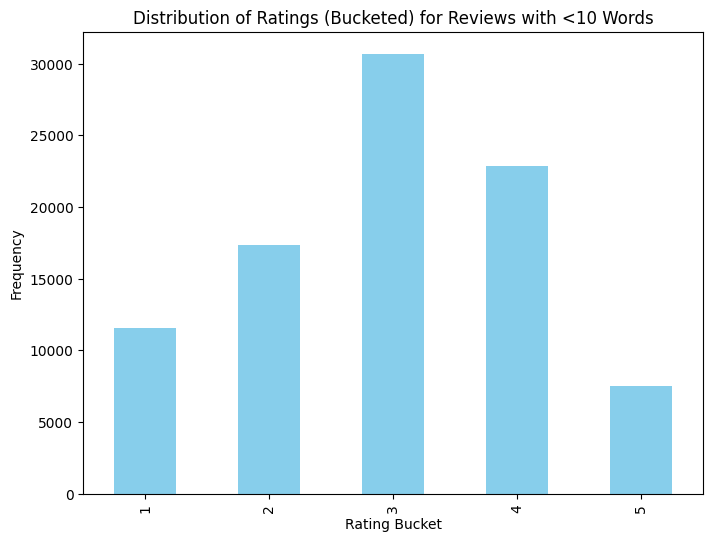

In [ ]:
plt.figure(figsize=(8, 6))
bucket_distribution_0_10.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings (Bucketed) for Reviews with <10 Words')
plt.xlabel('Rating Bucket')
plt.ylabel('Frequency')
plt.show()

For reviews that are shorter than ten words, the distribution of ratings is comparable to that of the entire dataset. With 30,689 reviews, bucket 3 is the most reviewed, followed by buckets 4 and 2, and bucket 5 has the fewest. This suggests that, even for extremely brief reviews, the rating patterns follow the general distribution and do not significantly deviate from it in light of the content's brevity.

#### 3.3.2 Word Count: 10-20

In [ ]:
subset_10_20 = df_cleaned[(df_cleaned['word_count'] >= 10) & (df_cleaned['word_count'] < 20)]

In [ ]:
# Analyze the distribution of bucketed scores in this subset
bucket_distribution_10_20 = subset_10_20['bucketed_score'].value_counts().sort_index()

# Print the distribution
print("Distribution of ratings (bucketed) for reviews with 10-20 words:")
print(bucket_distribution_10_20)

Distribution of ratings (bucketed) for reviews with 10-20 words:
bucketed_score
1    26242
2    49448
3    92755
4    62029
5    15899
Name: count, dtype: int64


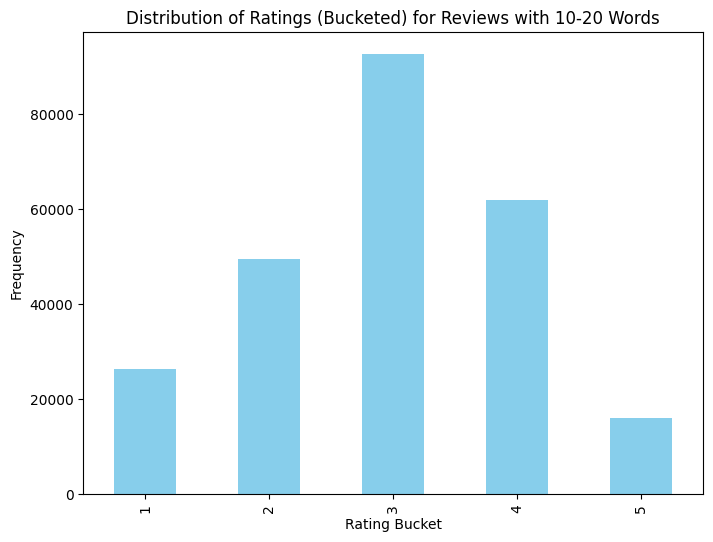

In [ ]:
plt.figure(figsize=(8, 6))
bucket_distribution_10_20.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings (Bucketed) for Reviews with 10-20 Words')
plt.xlabel('Rating Bucket')
plt.ylabel('Frequency')
plt.show()

The pattern seen in the distribution of ratings for reviews with 10–20 words is consistent with the dataset as a whole. With 92,755 reviews, bucket 3 has the most, followed by buckets 4 and 2. The least number of reviews are for buckets 1 and 5, with bucket 5 having the fewest. With fewer extreme ratings on either end, this distribution shows that mid-range ratings remain prevalent even as review length increases.

#### 3.3.3 Word Count 20-30

In [ ]:
subset_20_30 = df_cleaned[(df_cleaned['word_count'] >= 20) & (df_cleaned['word_count'] < 30)]

In [ ]:
# Analyze the distribution of bucketed scores in this subset
bucket_distribution_20_30 = subset_20_30['bucketed_score'].value_counts().sort_index()

# Print the distribution
print("Distribution of ratings (bucketed) for reviews with 20-30 words:")
print(bucket_distribution_20_30)

Distribution of ratings (bucketed) for reviews with 20-30 words:
bucketed_score
1     25573
2     53863
3    105294
4     70566
5     16678
Name: count, dtype: int64


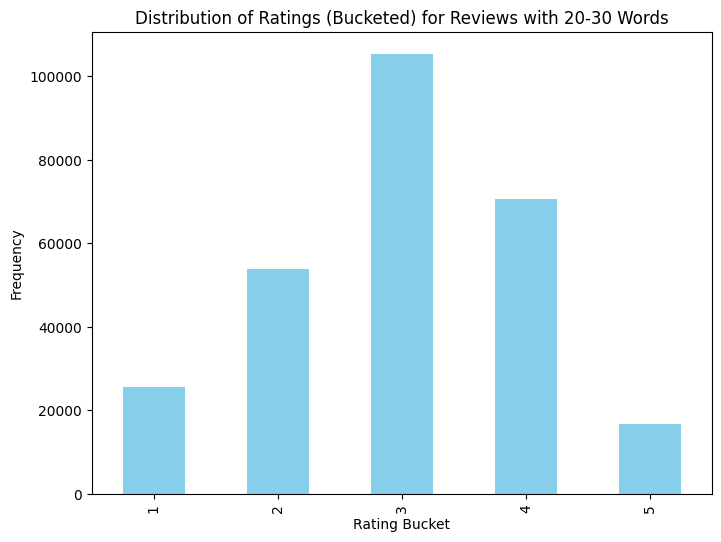

In [ ]:
plt.figure(figsize=(8, 6))
bucket_distribution_20_30.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings (Bucketed) for Reviews with 20-30 Words')
plt.xlabel('Rating Bucket')
plt.ylabel('Frequency')
plt.show()

Similar to previous subsets, the ratings distribution for reviews with 20–30 words follows a similar pattern. With more than 105,000 reviews, Bucket 3 is still the largest, suggesting that mid-range ratings hold sway even as review lengths grow. Bucket 3 has increased dramatically in comparison to the 10–20 word subset, while buckets 1 and 5 continue to be the smallest, despite the fact that buckets 2 and 4 have also consistently increased. This implies that, in contrast to shorter reviews, the trend of mid-range ratings with somewhat more balanced distributions between lower and higher ratings continues as reviews get longer.

#### 3.3.4 Word Count: >30

In [ ]:
subset_30_plus = df_cleaned[df_cleaned['word_count'] >= 30]

In [ ]:
# Analyze the distribution of bucketed scores in this subset
bucket_distribution_30_plus = subset_30_plus['bucketed_score'].value_counts().sort_index()

# Print the distribution
print("Distribution of ratings (bucketed) for reviews with 30+ words:")
print(bucket_distribution_30_plus)

Distribution of ratings (bucketed) for reviews with 30+ words:
bucketed_score
1    13218
2    28139
3    57629
4    39839
5     9870
Name: count, dtype: int64


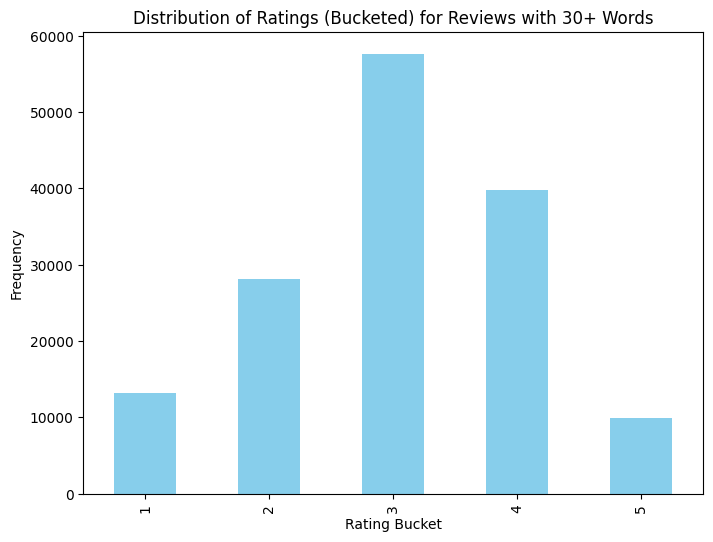

In [ ]:
plt.figure(figsize=(8, 6))
bucket_distribution_30_plus.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings (Bucketed) for Reviews with 30+ Words')
plt.xlabel('Rating Bucket')
plt.ylabel('Frequency')
plt.show()

The distribution of ratings in shorter subsets shows a consistent trend for reviews with 30 words or more. With 57,629 reviews, bucket 3 is still the most popular, followed by bucket 4 with 39,839 reviews. The fewest reviews are for buckets 1 and 5, indicating that mid-range ratings are still the most typical even in longer reviews. The distribution between buckets is somewhat more balanced than in shorter reviews, but the general trend of middle ratings predominating is the same for all review lengths.

## 4 Sentiment Analysis

The bert-base-multilingual-uncased-sentiment model is fine-tuned to predict ratings based on sentiment levels. Instead of just classifying text into basic sentiment categories (like positive, neutral, or negative), this model assigns a numeric rating that reflects the intensity or level of sentiment.

In [ ]:
# Preprocess the data: Convert DataFrame to Hugging Face Dataset
def preprocess_data(df):
    # Convert 'review_content' column to Dataset
    return Dataset.from_pandas(df[['review_content']])

# Compute sentiment polarity for a given batch using the 5-star model
def compute_rating_sentiment_polarity(batch, sentiment_model):
    results = sentiment_model(batch['review_content'])
    polarities = []

    # Update sentiment polarity mapping to match the model's text labels
    star_to_polarity = {
        '1 star': -1.0,  # 1 star -> most negative
        '2 stars': -0.5,  # 2 stars
        '3 stars': 0.0,   # 3 stars -> neutral
        '4 stars': 0.5,   # 4 stars
        '5 stars': 1.0    # 5 stars -> most positive
    }

    for result in results:
        label = result['label']  # Predicted label (e.g., '1 star', '2 stars', etc.)
        score = result['score']  # Confidence level of the prediction

        # Compute sentiment polarity by multiplying label score by confidence score
        polarity = star_to_polarity[label] * score
        polarities.append(polarity)

    # Add the computed polarities to the batch
    batch['rating_sentiment_polarity'] = polarities
    return batch

# Apply sentiment analysis in batches using the model
def apply_sentiment_analysis(df, sentiment_model, batch_size=128):
    dataset = preprocess_data(df)
    dataset = dataset.map(lambda batch: compute_rating_sentiment_polarity(batch, sentiment_model), batched=True, batch_size=batch_size)
    return dataset

# Main execution function to apply the sentiment model and convert back to pandas DataFrame
def run_sentiment_analysis(df, sentiment_model):
    # Apply sentiment analysis
    dataset = apply_sentiment_analysis(df, sentiment_model)

    # Convert Dataset back to pandas DataFrame and store results
    df['rating_sentiment_polarity'] = dataset['rating_sentiment_polarity']

    return df

In [ ]:
# Load the sentiment analysis model (on GPU if available)
rating_sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=0)

In [ ]:
# Run sentiment analysis
df_cleaned = run_sentiment_analysis(df_cleaned, rating_sentiment_model)

Map:   0%|          | 0/757062 [00:00<?, ? examples/s]

In [ ]:
# Check the resulting DataFrame
print(df_cleaned[['review_content', 'rating_sentiment_polarity']].head())

                                      review_content  \
3  Whether audiences will get behind The Lightnin...   
6  Harry Potter knockoffs don't come more transpa...   
7  Percy Jackson isn't a great movie, but it's a ...   
8                         Fun, brisk and imaginative   
9  Crammed with dragons, set-destroying fights an...   

   rating_sentiment_polarity  
3                   0.000000  
6                  -0.410805  
7                   0.253021  
8                   0.231060  
9                  -0.149372  


Saving sentiment polarity computations to Google Drive

In [ ]:
output_file_path = '/content/drive/My Drive/Work Project/archive/df_sentiment_polarity.csv'

df_cleaned.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

DataFrame saved to /content/drive/My Drive/Work Project/archive/df_sentiment_polarity.csv


Reloading the data to continue with the analysis

In [ ]:
file_path = '/content/drive/My Drive/Work Project/Data/Rotten Tomatoes/archive/df_sentiment_polarity.csv'

df_cleaned = pd.read_csv(file_path)

df_cleaned

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,score_category,normalized_score,rounded_score,bucketed_score,word_count,vader_sentiment_polarity,twitter_sentiment_polarity,financial_sentiment_polarity,rating_sentiment_polarity
0,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...,Other,3.50,4.0,3,37,0.7050,0.666008,0.460661,0.000000
1,m/0814255,Nick Schager,False,Slant Magazine,Rotten,1/4,2010-02-10,Harry Potter knockoffs don't come more transpa...,Fraction,1.25,1.0,1,17,0.0000,-0.523744,0.499784,-0.410805
2,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ...",Other,3.50,4.0,3,23,0.7143,0.875983,0.432302,0.253021
3,m/0814255,Jordan Hoffman,False,UGO,Fresh,B,2010-02-10,"Fun, brisk and imaginative",Letter Grade,4.00,4.0,4,4,0.5994,0.868087,0.499907,0.231060
4,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,3/5,2010-02-10,"Crammed with dragons, set-destroying fights an...",Fraction,3.00,3.0,3,30,0.3400,0.279836,0.499806,-0.149372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757057,m/zulu,NaN,False,Empire Magazine,Fresh,4/5,2017-07-10,As a spectacular war film with a powerful mora...,Fraction,4.00,4.0,4,10,-0.2732,0.828359,0.499865,0.768415
757058,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme...",Other,3.50,4.0,3,18,-0.0286,0.647083,0.473216,0.246188
757059,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...,Letter Grade,4.30,4.0,4,14,0.0000,0.553140,0.499921,-0.175630
757060,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th...",Other,3.50,4.0,3,45,-0.7018,-0.488166,0.499922,0.000000


## 5 Correlation Analysis

In the following section the sentiment polarity results will be analyzed, specifically looking at correlation with corresponding ratings

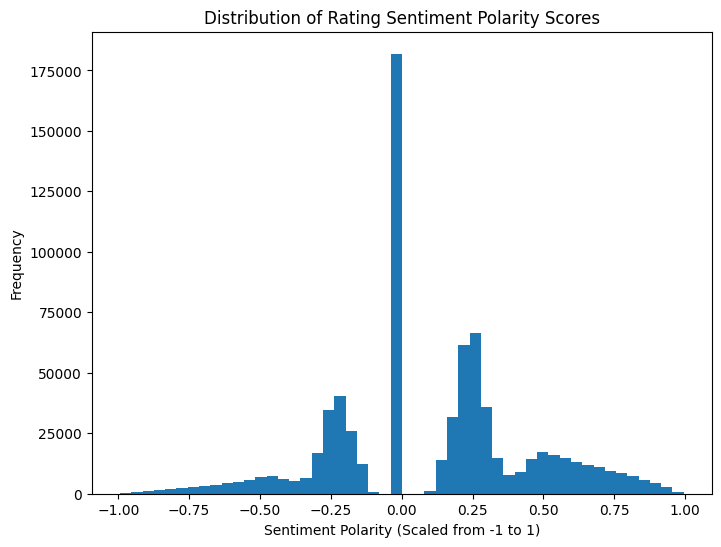

In [ ]:
plt.figure(figsize=(8, 6))
df_cleaned['rating_sentiment_polarity'].hist(bins=50)
plt.title('Distribution of Rating Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity (Scaled from -1 to 1)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [ ]:
# Filter Reviews with Sentiment Polarity > 0.75 and < -0.75
higher_than_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] > 0.75]
smaller_than_minus_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] < -0.75]

# Count the number of reviews in both categories
count_higher_than_075_rating = higher_than_075_rating.shape[0]
count_smaller_than_minus_075_rating = smaller_than_minus_075_rating.shape[0]

# Output the counts
print(f"Number of reviews with polarity > 0.75 (Rating): {count_higher_than_075_rating}")
print(f"Number of reviews with polarity < -0.75 (Rating): {count_smaller_than_minus_075_rating}")

Number of reviews with polarity > 0.75 (Rating): 30977
Number of reviews with polarity < -0.75 (Rating): 8462


In [ ]:
# Calculate Spearman Correlation between Rating Sentiment Polarity and Bucketed Score
spearman_corr_rating, spearman_pval_rating = spearmanr(df_cleaned['rating_sentiment_polarity'], df_cleaned['normalized_score'])

# Output the correlation result
print(f"\nSpearman correlation (Rating): {spearman_corr_rating}, p-value: {spearman_pval_rating}")


Spearman correlation (Rating): 0.5148627590073492, p-value: 0.0


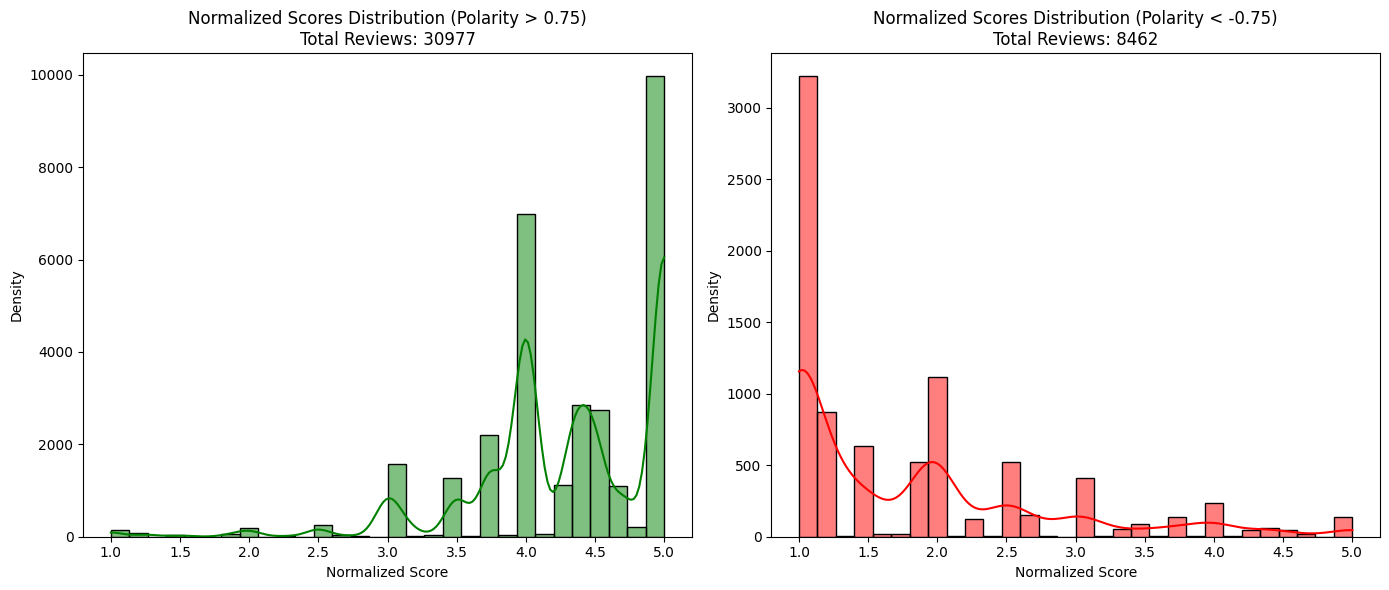

In [ ]:
# Filter Reviews with Sentiment Polarity > 0.75 and < -0.75
higher_than_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] > 0.75]
smaller_than_minus_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] < -0.75]

# Plot the distribution of normalized scores with KDE for reviews with polarity > 0.75 and < -0.75
plt.figure(figsize=(14, 6))

# KDE plot for normalized scores with polarity > 0.75
plt.subplot(1, 2, 1)
sns.histplot(higher_than_075_rating['normalized_score'], kde=True, color='green', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity > 0.75)\nTotal Reviews: {higher_than_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

# KDE plot for normalized scores with polarity < -0.75
plt.subplot(1, 2, 2)
sns.histplot(smaller_than_minus_075_rating['normalized_score'], kde=True, color='red', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity < -0.75)\nTotal Reviews: {smaller_than_minus_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

These plots support the idea that high positive polarity strongly correlates with ratings near the maximum score (4.0-5.0), while high negative polarity correlates with the minimum scores (1.0-2.0).

This distribution is also appropriate for a regression model as it provides more nuanced insight into how sentiment affects score variation across the entire spectrum, rather than discrete categories.

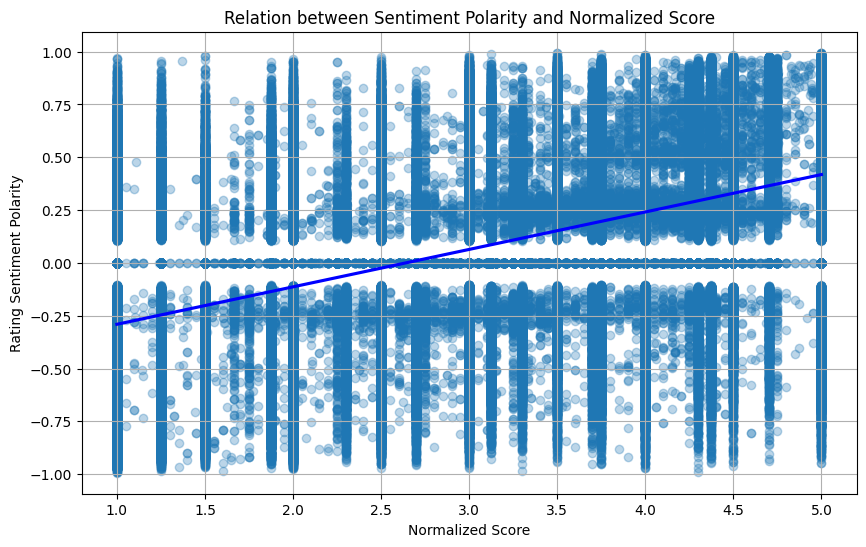

Number of outliers: 30427
                                           review_content  normalized_score  \
272     As fabulous and fantastic as anything he has e...          3.500000   
1863    Economic repression by competitive market forc...          3.500000   
2106    Amazing Grace marks an unforgettable and regre...          3.500000   
2444           As ridiculous as it is uproariously funny.          3.500000   
5918    One of the grimmest end-of-the-world movies in...          3.500000   
...                                                   ...               ...   
348146  Contrived and somewhat dull, but the talented ...          3.505000   
251980  Often contrived, stilted and awkwardly preachy...          2.725000   
417508  Solid performances can't save the film from it...          2.725000   
735238  An enchanting, provocative, bighearted story t...          4.095000   
677891  It's not that The Science of Sleep is a terrib...          2.272727   

        rating_sentiment_

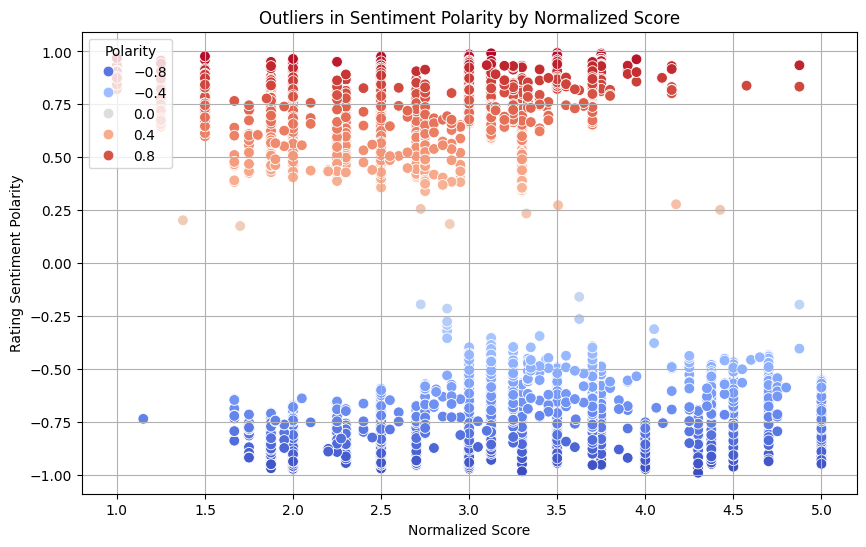

In [ ]:
# Define the function to identify outliers
def identify_outliers(df, column, score_column):
    outliers = pd.DataFrame()
    for score in df[score_column].unique():
        score_data = df[df[score_column] == score]
        Q1 = score_data[column].quantile(0.25)
        Q3 = score_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_in_score = score_data[(score_data[column] < lower_bound) | (score_data[column] > upper_bound)]
        outliers = pd.concat([outliers, outliers_in_score])
    return outliers

# Scatter plot with regression line for continuous relation
plt.figure(figsize=(10, 6))
sns.regplot(x='normalized_score', y='rating_sentiment_polarity', data=df_cleaned, scatter_kws={'alpha':0.3}, line_kws={'color': 'blue'})
plt.title('Relation between Sentiment Polarity and Normalized Score')
plt.xlabel('Normalized Score')
plt.ylabel('Rating Sentiment Polarity')
plt.grid(True)
plt.show()

# Perform outlier analysis using the defined function
outliers = identify_outliers(df_cleaned, 'rating_sentiment_polarity', 'normalized_score')
outliers_selected_columns = outliers[['review_content', 'normalized_score', 'rating_sentiment_polarity']]
print("Number of outliers:", len(outliers_selected_columns))
print(outliers_selected_columns)

# Scatter plot for outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_score', y='rating_sentiment_polarity', data=outliers, hue='rating_sentiment_polarity', palette='coolwarm', edgecolor='w', s=60)
plt.title('Outliers in Sentiment Polarity by Normalized Score')
plt.xlabel('Normalized Score')
plt.ylabel('Rating Sentiment Polarity')
plt.legend(title='Polarity', loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Filtering for Extreme Positive Sentiment with Low Ratings
extreme_positive_low_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] > 0.75) &
    (df_cleaned['normalized_score'] <= 3)
]

# Filtering for Extreme Negative Sentiment with High Ratings
extreme_negative_high_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] < -0.75) &
    (df_cleaned['normalized_score'] >= 3)
]

# Displaying the outliers for extreme positive sentiment with low ratings
print("Extreme Positive Sentiment with Low Ratings (Sample):")
print(extreme_positive_low_rating[['review_content', 'normalized_score', 'rating_sentiment_polarity']].head(10))

# Displaying the outliers for extreme negative sentiment with high ratings
print("\nExtreme Negative Sentiment with High Ratings (Sample):")
print(extreme_negative_high_rating[['review_content', 'normalized_score', 'rating_sentiment_polarity']].head(10))


Extreme Positive Sentiment with Low Ratings (Sample):
                                         review_content  normalized_score  \
189   Real joys and sorrows must be bigger and deepe...             2.500   
282   Roland Emmerich has a remarkable talent for dr...             1.500   
307   The best acting comes from woolly mammoths, ma...             1.250   
397           A remarkably beautiful yet soulless film.             1.875   
1266  Pierce Brosnan oferece, aqui, um dos melhores ...             3.000   
1326  This crude, inspirational tear-jerker is as sw...             1.000   
1847                    ...gorgeously-shot, melancholy.             3.000   
2089  An inspirational, moving and wonderfully well-...             3.000   
2333  The most impressive thing about Interview is h...             2.500   
2831  A splendidly mounted and visually imaginative ...             3.000   

      rating_sentiment_polarity  
189                    0.862460  
282                    0.75581


This approach systematically identifies and quantifies outliers that exhibit a discrepancy between sentiment polarity and normalized score, specifically targeting instances where extremely positive sentiment corresponds to low ratings and extremely negative sentiment aligns with high ratings. By filtering for cases where high sentiment polarity (> 0.75) is paired with low scores (<= 3), and low sentiment polarity (< -0.75) is paired with high scores (>= 3), the analysis captures reviews in which the expected relationship between sentiment and rating is inverted. This method facilitates an understanding of instances where the sentiment analysis may diverge from the reviewer’s assigned rating, potentially due to factors such as sarcasm, mixed sentiments, or nuanced expressions of opinion.

In [ ]:
# Filtering for Extreme Positive Sentiment with Low Ratings
extreme_positive_low_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] > 0.75) &
    (df_cleaned['normalized_score'] <= 3)
]

# Filtering for Extreme Negative Sentiment with High Ratings
extreme_negative_high_rating = df_cleaned[
    (df_cleaned['rating_sentiment_polarity'] < -0.75) &
    (df_cleaned['normalized_score'] >= 3)
]

# Counting the number of outliers in each category
count_extreme_positive_low_rating = extreme_positive_low_rating.shape[0]
count_extreme_negative_high_rating = extreme_negative_high_rating.shape[0]

# Displaying the counts
print("Count of Extreme Positive Sentiment with Low Ratings:")
print(count_extreme_positive_low_rating)
print()
print("Count of Extreme Negative Sentiment with High Ratings:"  )
print(count_extreme_negative_high_rating)


Count of Extreme Positive Sentiment with Low Ratings:
2061

Count of Extreme Negative Sentiment with High Ratings:
1242


The counts reveal that there are 784 instances of extreme positive sentiment paired with low ratings and 779 instances of extreme negative sentiment associated with high ratings. This indicates a roughly balanced presence of such outliers in the dataset.


In [ ]:
# Verifying the new dataset size before removing the outliers
df_cleaned.shape

(757062, 17)

In [ ]:
# Dropping the identified outliers from the dataset
df_cleaned = df_cleaned.drop(extreme_positive_low_rating.index)
df_cleaned = df_cleaned.drop(extreme_negative_high_rating.index)

# Verifying the new dataset size after removing the outliers
df_cleaned.shape

(753759, 17)

The decision to exclude these outliers from the dataset is based on their atypical relationship between sentiment polarity and normalized score. Instances where highly positive sentiment is paired with low ratings, and highly negative sentiment with high ratings, represent a divergence from the expected correlation, potentially due to factors such as sarcasm, mixed sentiments, or inconsistencies in sentiment detection. By removing these cases, the analysis aims to reduce noise and enhance the model's ability to learn from more consistent data patterns, thereby improving the reliability and validity of predictive outcomes in subsequent analyses.

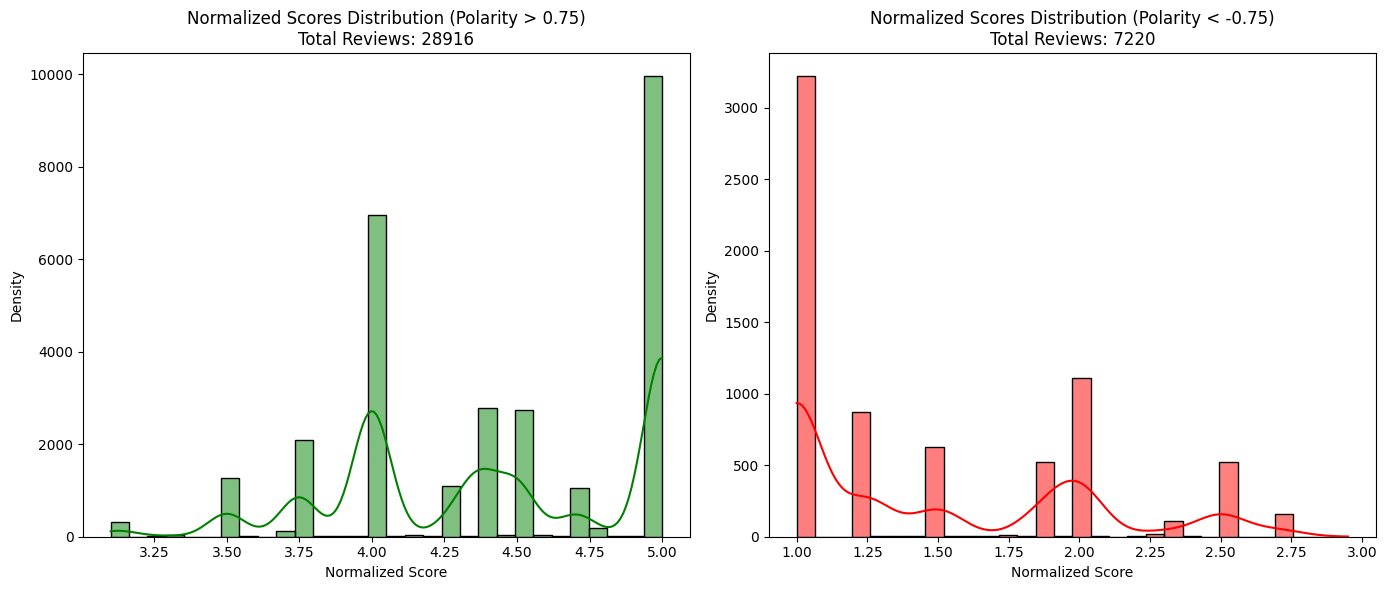

In [ ]:
# Filter Reviews with Sentiment Polarity > 0.75 and < -0.75
higher_than_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] > 0.75]
smaller_than_minus_075_rating = df_cleaned[df_cleaned['rating_sentiment_polarity'] < -0.75]

# Plot the distribution of normalized scores with KDE for reviews with polarity > 0.75 and < -0.75
plt.figure(figsize=(14, 6))

# KDE plot for normalized scores with polarity > 0.75
plt.subplot(1, 2, 1)
sns.histplot(higher_than_075_rating['normalized_score'], kde=True, color='green', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity > 0.75)\nTotal Reviews: {higher_than_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

# KDE plot for normalized scores with polarity < -0.75
plt.subplot(1, 2, 2)
sns.histplot(smaller_than_minus_075_rating['normalized_score'], kde=True, color='red', bins=30)
plt.title(f'Normalized Scores Distribution (Polarity < -0.75)\nTotal Reviews: {smaller_than_minus_075_rating.shape[0]}')
plt.xlabel('Normalized Score')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Removing the outliers has reduced the discrepancies, leading to a distribution that better reflects the correlation between sentiment polarity and normalized score. This should help the model to learn more effectively from the data, as it now represents a more straightforward relationship between sentiment and rating. Great work on refining the dataset!

##### 4.5.4 Findings & Interpretation



-> Twitter RoBERTa has the strongest correlation and captures extreme sentiment well, though it may lack middle-ground sentiment scores.

-> Rating Sentiment Polarity has a similar correlation but offers a more balanced distribution across the sentiment range, making it a good middle ground.

-> VADER shows a weaker correlation but does capture a reasonable spread of sentiments, making it a decent option but not the best.


The decision was made to use Five-Class Polarity (Rating Sentiment Polarity) because it provides a more balanced distribution of sentiment scores, particularly across a wider range of categories. Unlike Three-Class Polarity (Twitter RoBERTa), which is excellent at capturing extreme sentiment but struggles with middle-ground sentiment, Five-Class Polarity distinguishes more clearly between extreme polarities and middle scores. This makes it a more comprehensive approach because it captures both the intensity and nuances of sentiment in all categories.

## 6 Data Export

### 5.1 Modeling dataset

Renaming to sentiment polarity and rating

In [ ]:
# Rename 'rating_sentiment_polarity' to 'sentiment_polarity'
df_cleaned = df_cleaned.rename(columns={'rating_sentiment_polarity': 'sentiment_polarity'})

df_cleaned = df_cleaned.rename(columns={'bucketed_score': 'rating'})

In [ ]:
df_cleaned

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_date,review_content,rating,word_count,sentiment_polarity
0,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,2010-02-09,"Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it's an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of?",3,37,0.000000
1,m/0814255,Nick Schager,False,Slant Magazine,Rotten,2010-02-10,Harry Potter knockoffs don't come more transparent and slapdash than this wannabe-franchise jumpstarter directed by Chris Columbus.,1,17,-0.410805
2,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,2010-02-10,"Percy Jackson isn't a great movie, but it's a good one, trotting out kernels of Greek mythology like so many Disney Channel references.",3,23,0.253021
3,m/0814255,Jordan Hoffman,False,UGO,Fresh,2010-02-10,"Fun, brisk and imaginative",4,4,0.231060
4,m/0814255,Jim Schembri,True,The Age (Australia),Fresh,2010-02-10,"Crammed with dragons, set-destroying fights and things exploding, [Columbus] squeezes in a few well-meaning pause breaks about friendship and absent fathers before swiftly moving on to the next pyrotechnics display.",3,30,-0.149372
...,...,...,...,...,...,...,...,...,...,...
757057,m/zulu,NaN,False,Empire Magazine,Fresh,2017-07-10,As a spectacular war film with a powerful moral dimension.,4,10,0.768415
757058,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,2007-03-07,"Seen today, it's not only a startling indictment of British imperialism, but it seems a remarkably forward-thinking work.",3,18,0.246188
757059,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,2010-09-16,A rousing visual spectacle that's a prequel of the Cy Endfield directed Zulu (1964).,4,14,-0.175630
757060,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,2011-02-28,"A simple two-act story: Prelude to war, and the war. The former is concerned with a lot of British derring-do and priggish behavior. The latter consists of battle scenes with a lot of kinetic energy but not as much emotional punch as they should have.",3,45,0.000000


In [ ]:
output_file_path = '/content/drive/My Drive/Work Project/Data/Rotten Tomatoes/archive/df_modeling_2.csv'

df_cleaned.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

DataFrame saved to /content/drive/My Drive/Work Project/Data/Rotten Tomatoes/archive/df_modeling_2.csv


### 5.2 Subsets (word_count)

Saving data subsets prepared in section 3.3 of this notebook to Google Drive

In [ ]:
# Filter reviews by word count ranges
subset_0_10 = df_cleaned[df_cleaned['word_count'] < 10]
subset_10_20 = df_cleaned[(df_cleaned['word_count'] >= 10) & (df_cleaned['word_count'] < 20)]
subset_20_30 = df_cleaned[(df_cleaned['word_count'] >= 20) & (df_cleaned['word_count'] < 30)]
subset_30_plus = df_cleaned[df_cleaned['word_count'] >= 30]

# Count the number of reviews in each subset
count_0_10 = len(subset_0_10)
count_10_20 = len(subset_10_20)
count_20_30 = len(subset_20_30)
count_30_plus = len(subset_30_plus)

# Print the counts for each subset
print(f"Number of reviews with 0-10 words: {count_0_10}")
print(f"Number of reviews with 10-20 words: {count_10_20}")
print(f"Number of reviews with 20-30 words: {count_20_30}")
print(f"Number of reviews with 30+ words: {count_30_plus}")

Number of reviews with 0-10 words: 90020
Number of reviews with 10-20 words: 246373
Number of reviews with 20-30 words: 271974
Number of reviews with 30+ words: 148695


In [ ]:
# Define the paths to save the subsets in Google Drive
path_0_10 = '/content/drive/My Drive/Work Project/archive/Subset_0_10_words.csv'
path_10_20 = '/content/drive/My Drive/Work Project/archive/Subset_10_20_words.csv'
path_20_30 = '/content/drive/My Drive/Work Project/archive/Subset_20_30_words.csv'
path_30_plus = '/content/drive/My Drive/Work Project/archive/Subset_30_plus_words.csv'

In [ ]:
# Save the subsets to Google Drive as CSV files
subset_0_10.to_csv(path_0_10, index=False)
subset_10_20.to_csv(path_10_20, index=False)
subset_20_30.to_csv(path_20_30, index=False)
subset_30_plus.to_csv(path_30_plus, index=False)

print("Subsets saved to Google Drive.")

Subsets saved to Google Drive.


## 6 Written Summary of Insights

To guarantee consistency throughout the analysis, the dataset underwent extensive preprocessing, which included handling missing values and standardizing review scores. To offer a structured rating system for prediction tasks, review scores were divided into discrete buckets (1–5). Floor rounding was used to guarantee a conservative rating methodology.

To investigate the impact of review length on rating predictions, four subsets were built based on word count: reviews with fewer than 10 words, 10-20 words, 20-30 words, and more than 30 words. Each subset contained sufficient data to fine-tune the transformer models, and the rating distribution was similar across all subsets, ensuring comparability for statistical analysis.

Sentiment polarity was introduced to capture the subtle differences between neutral, positive, and negative sentiments in movie reviews. It is defined as a numerical scale with a range of -1 to 1. A number of methods were compared, such as multiple BERT-based approaches, like three-class and five-class sentiment classification, and VADER-based sentiment polarity. In the end, the most logical results were obtained by the nlptown/bert-base-multilingual-uncased-sentiment model, which divides sentiment into five different categories. The model's output labels were scaled to a range of -1 to 1 by multiplying them by the corresponding confidence scores, which further refined the sentiment polarity.

Further analysis of the relationship between extreme sentiment polarity and ratings was conducted using thresholds of 0.75 and -0.75, providing deeper insights into highly polarized reviews. Extreme ratings (1–5) and their associated sentiment polarity showed a strong Spearman correlation of 0.51 (p-value = 0) when using these thresholds to define extreme polarities. When the polarity thresholds were increased to 0.9 and -0.9, the Spearman correlation also increased to 0.57 (p-value = 0), further reinforcing the link between extreme sentiment polarity and ratings.

Given the large size of the dataset, GPU acceleration and batch processing were employed to speed up the sentiment analysis, which significantly improved computational efficiency while processing over 1 million rows of data.


